<a href="https://colab.research.google.com/github/alfandoo/-Ride-Hailing-Analytics-Project-/blob/main/ride_analytics_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚗 Indonesia Ride Bookings — End-to-End Analytics

**Pipeline:** Load → Clean → Feature Engineer → KPIs → Visualize → Export Reports

---

## 0 · Setup

In [68]:
from __future__ import annotations

import logging
import sys
import warnings
from dataclasses import dataclass, field
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print('✓ Libraries loaded')

✓ Libraries loaded


## 1 · Configuration



In [90]:
@dataclass
class Config:
    # ── I/O ───────────────────────────────────
    input_path : str  = 'indonesia_ride_bookings_FILLED.csv'
    output_dir : str  = 'output'
    save_plots : bool = True

    # ── Display ───────────────────────────────
    figure_dpi        : int   = 130
    top_n_locations   : int   = 15
    top_n_routes      : int   = 20
    rolling_window    : int   = 7
    completion_target : float = 75.0   # % — above = EXCELLENT

    # ── Column names ──────────────────────────
    BOOKING_ID      : str = 'Booking ID'
    CUSTOMER_ID     : str = 'Customer ID'
    DATE            : str = 'Date'
    TIME            : str = 'Time'
    STATUS          : str = 'Booking Status'
    VEHICLE         : str = 'Vehicle Type'
    PAYMENT         : str = 'Payment Method'
    VALUE           : str = 'Booking Value'
    DISTANCE        : str = 'Ride Distance'
    DRIVER_RATING   : str = 'Driver Ratings'
    CUST_RATING     : str = 'Customer Rating'
    PICKUP          : str = 'Pickup Location'
    DROP            : str = 'Drop Location'
    VTAT            : str = 'Avg VTAT'
    CTAT            : str = 'Avg CTAT'
    CANCEL_CUST     : str = 'Cancelled Rides by Customer'
    CANCEL_DRIVER   : str = 'Cancelled Rides by Driver'
    INCOMPLETE      : str = 'Incomplete Rides'
    REASON_CUST     : str = 'Reason for cancelling by Customer'
    REASON_DRIVER   : str = 'Driver Cancellation Reason'

    # ── Status values ─────────────────────────
    COMPLETED : str = 'Completed'
    CANCEL_C  : str = 'Cancelled by Customer'
    CANCEL_D  : str = 'Cancelled by Driver'
    NO_DRIVER : str = 'No Driver Found'
    INCOMPLETE: str = 'Incomplete'

    # ── City mapping ──────────────────────────
    city_map: dict = field(default_factory=lambda: {
        'Jakarta': [
            'Monas','Bundaran HI','Senayan','Thamrin','Sudirman','Blok M',
            'Kemang','Menteng','Kuningan','Kebayoran Baru','Kelapa Gading',
            'Pluit','PIK','Mangga Dua','Kota Tua','Ancol','Tebet','Sarinah',
            'Grand Indonesia','Plaza Indonesia','SCBD','Pondok Indah','Lebak Bulus',
            'Fatmawati','Cipete','Pasar Minggu','Cawang','Rawamangun','Pulo Gadung',
            'Matraman','Kampung Melayu','Senayan City','Pacific Place','Gambir Station',
            'Halim Airport','Pasar Rebo','Kalibata','Cilandak',
        ],
        'Tangerang': [
            'Alam Sutera','BSD City','Gading Serpong','Karawaci','Bintaro',
            'Serpong','Summarecon Serpong','AEON Mall BSD','Soekarno Hatta Airport',
            'Tangcity Mall','Ciledug',
        ],
        'Bekasi': [
            'Summarecon Bekasi','Kalimalang','Galaxy Bekasi','Harapan Indah',
            'Tambun','Bekasi Cyber Park','Blu Plaza','Metropolitan Mall',
            'Grand Galaxy Park','Galaxy Mall',
        ],
        'Depok': [
            'Margonda','UI Depok','Depok Town Square','Margo City','Pancoran Mas',
            'Lenteng Agung','Cibubur','Citayam',
        ],
        'Bogor': [
            'Kebun Raya Bogor','Bogor Trade Mall','Botani Square','Tajur',
            'Dramaga','Bogor Station','Ekalokasari Plaza',
        ],
        'Bandung': [
            'Dago','Cihampelas','Buah Batu','Cimahi','Trans Studio Bandung',
            'Paris Van Java','Festival CityLink','Braga','Setiabudhi',
            'Antapani','Cicaheum','Cibiru','Ciumbuleuit','Bandung Station',
            'Pasir Kaliki','Husein Airport','Riau',
        ],
        'Surabaya': [
            'Tunjungan Plaza','Pakuwon Mall','Juanda Airport','Darmo','Gubeng',
            'Kenjeran','Suramadu','Monumen Kapal Selam','Rungkut','HR Muhammad',
            'Ciputra World','Basuki Rahmat','Marina','Waru',
        ],
        'Semarang': [
            'Simpang Lima','Paragon Mall','Java Mall','Kota Lama','Citraland',
            'Ahmad Yani Airport','Ungaran','Tembalang','Pandanaran',
            'Kota Lama Semarang',
        ],
        'Yogyakarta': [
            'Malioboro','Alun-alun Kidul','Prawirotaman','Hartono Mall',
            'Jogja City Mall','UGM','Adisucipto Airport','Sleman','Kaliurang',
        ],
    })


cfg = Config()
OUT = Path(cfg.output_dir)
OUT.mkdir(parents=True, exist_ok=True)

MONTH_ORDER  = ['January','February','March','April','May','June',
                'July','August','September','October','November','December']
DAY_ORDER    = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
PERIOD_ORDER = ['Morning','Afternoon','Evening','Night']
DIST_ORDER   = ['Short (<5 km)','Medium (5–15 km)','Long (15–30 km)','Very Long (>30 km)']
WEEKENDS     = {'Saturday','Sunday'}

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

def savefig(fig: plt.Figure, name: str) -> None:
    plt.tight_layout()
    if cfg.save_plots:
        fig.savefig(OUT / f'{name}.png', dpi=cfg.figure_dpi, bbox_inches='tight')
    plt.show()
    plt.close(fig)

print(f'✓ Config ready  |  Output → {OUT.resolve()}')

✓ Config ready  |  Output → /content/output


---
## 2 · Load Data

In [70]:
path = Path(cfg.input_path)
if not path.exists():
    raise FileNotFoundError(f'Dataset not found: {path.resolve()}')

df = pd.read_csv(path)
print(f'✓ Loaded  {len(df):,} rows × {df.shape[1]} columns')
df.head()

✓ Loaded  137,364 rows × 21 columns


,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-08-07,17:02:07,"""IND6838089""",Completed,"""CID3018529""",inDriver Bike,Lenteng Agung,Citayam,2.07,42.50,NaN,NaN,NaN,NaN,NaN,NaN,59300.00,17.76,4.50,4.50,Tunai
1,2024-07-08,08:11:59,"""IND2542236""",Completed,"""CID4262330""",BlueBird Taxi,Dramaga,Botani Square,8.75,52.70,NaN,NaN,NaN,NaN,NaN,NaN,82500.00,6.88,5.00,5.00,DANA
2,2024-05-10,06:00:05,"""IND6826583""",Completed,"""CID4142605""",inDriver Car,Pancoran Mas,Citayam,9.84,42.90,NaN,NaN,NaN,NaN,NaN,NaN,76700.00,12.03,5.00,5.00,ShopeePay
3,2024-08-26,05:39:50,"""IND2020147""",Completed,"""CID9831969""",GrabCar,Malioboro,Prawirotaman,6.32,8.60,NaN,NaN,NaN,NaN,NaN,NaN,73300.00,14.13,5.00,3.00,Tunai
4,2024-06-22,17:33:45,"""IND7194624""",Completed,"""CID5112267""",GrabBike,Juanda Airport,Darmo,6.57,16.30,NaN,NaN,NaN,NaN,NaN,NaN,69300.00,14.89,5.00,4.00,Kartu Debit


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137364 entries, 0 to 137363
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               137364 non-null  object 
 1   Time                               137364 non-null  object 
 2   Booking ID                         137364 non-null  object 
 3   Booking Status                     137364 non-null  object 
 4   Customer ID                        137364 non-null  object 
 5   Vehicle Type                       137364 non-null  object 
 6   Pickup Location                    137364 non-null  object 
 7   Drop Location                      137364 non-null  object 
 8   Avg VTAT                           137364 non-null  float64
 9   Avg CTAT                           116796 non-null  float64
 10  Cancelled Rides by Customer        9440 non-null    float64
 11  Reason for cancelling by Customer  1578

---
## 3 · Clean & Feature Engineer

In [72]:
# ── Clean IDs ────────────────────────────────
for col in [cfg.BOOKING_ID, cfg.CUSTOMER_ID]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace('"', '', regex=False)

# ── Parse datetime ───────────────────────────
df[cfg.DATE]  = pd.to_datetime(df[cfg.DATE])
df['DateTime'] = pd.to_datetime(df[cfg.DATE].astype(str) + ' ' + df[cfg.TIME])

# ── Time features ────────────────────────────
df['Year']           = df[cfg.DATE].dt.year
df['Month']          = df[cfg.DATE].dt.month
df['Month_Name']     = df[cfg.DATE].dt.strftime('%B')
df['Day']            = df[cfg.DATE].dt.day
df['DayOfWeek']      = df[cfg.DATE].dt.dayofweek
df['DayOfWeek_Name'] = df[cfg.DATE].dt.strftime('%A')
df['Hour']           = df['DateTime'].dt.hour
df['Quarter']        = df[cfg.DATE].dt.quarter

def time_period(h):
    if 5  <= h < 12: return 'Morning'
    if 12 <= h < 17: return 'Afternoon'
    if 17 <= h < 21: return 'Evening'
    return 'Night'

df['Time_Period'] = df['Hour'].map(time_period)

# ── Replace null strings, convert numerics ───
df = df.replace('null', np.nan)

for col in [cfg.VTAT, cfg.CTAT, cfg.VALUE, cfg.DISTANCE, cfg.DRIVER_RATING, cfg.CUST_RATING]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

for col in [cfg.CANCEL_CUST, cfg.CANCEL_DRIVER, cfg.INCOMPLETE]:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)

# ── City features ────────────────────────────
loc_to_city = {loc: city for city, locs in cfg.city_map.items() for loc in locs}
df['Pickup_City'] = df[cfg.PICKUP].str.replace('"','',regex=False).map(loc_to_city).fillna('Other')
df['Drop_City']   = df[cfg.DROP].str.replace('"','',regex=False).map(loc_to_city).fillna('Other')

# ── Route & distance category ────────────────
df['Route'] = df[cfg.PICKUP] + ' → ' + df[cfg.DROP]

def dist_cat(d):
    if   d <  5: return 'Short (<5 km)'
    elif d < 15: return 'Medium (5–15 km)'
    elif d < 30: return 'Long (15–30 km)'
    else:        return 'Very Long (>30 km)'

df['Distance_Category'] = df[cfg.DISTANCE].apply(lambda x: dist_cat(x) if pd.notna(x) else np.nan)

# ── Completed rides subset ───────────────────
completed = df[df[cfg.STATUS] == cfg.COMPLETED].copy()

print(f'✓ Cleaned  |  Date range: {df[cfg.DATE].min().date()} → {df[cfg.DATE].max().date()}')
print(f'   Total rows: {len(df):,}  |  Completed: {len(completed):,}')

✓ Cleaned  |  Date range: 2024-01-01 → 2024-12-31
   Total rows: 137,364  |  Completed: 123,678


In [73]:
# Missing value summary
missing = df.isnull().sum()
missing = missing[missing > 0].rename('Count').to_frame()
missing['Pct (%)'] = (missing['Count'] / len(df) * 100).round(2)
missing.sort_values('Count', ascending=False)

,Count,Pct (%)
Incomplete Rides Reason,135933,98.96
Driver Cancellation Reason,126528,92.11
Reason for cancelling by Customer,121577,88.51
Booking Value,30938,22.52
Payment Method,30938,22.52
Avg CTAT,20568,14.97
Ride Distance,13686,9.96
Driver Ratings,13686,9.96
Customer Rating,13686,9.96
Distance_Category,13686,9.96


---
## 4 · Key Business KPIs

In [91]:
total         = len(df)
comp_count    = len(completed)
total_revenue = completed[cfg.VALUE].sum()
avg_value     = completed[cfg.VALUE].mean()
date_days     = (df[cfg.DATE].max() - df[cfg.DATE].min()).days + 1
cancel_c_df   = df[df[cfg.STATUS] == cfg.CANCEL_C]
cancel_d_df   = df[df[cfg.STATUS] == cfg.CANCEL_D]
no_driver_df  = df[df[cfg.STATUS] == cfg.NO_DRIVER]
incomplete_df = df[df[cfg.STATUS] == cfg.INCOMPLETE]

completion_rate   = comp_count / total * 100
cancellation_rate = (len(cancel_c_df) + len(cancel_d_df) + len(no_driver_df) + len(incomplete_df)) / total * 100
label = 'EXCELLENT ✓' if completion_rate >= cfg.completion_target else 'NEEDS IMPROVEMENT ⚠'

SEP = '=' * 60
print(SEP)
print('KEY BUSINESS METRICS')
print(SEP)
print(f'  Total Bookings        {total:>12,}')
print(f'  Completed Bookings    {comp_count:>12,}')
print(f'  Completion Rate       {completion_rate:>11.2f}%  → {label}')
print(f'  Cancellation Rate     {cancellation_rate:>11.2f}%')
print()
print(f'  Total Revenue         Rp {total_revenue:>14,.0f}')
print(f'  Avg Booking Value     Rp {avg_value:>14,.0f}')
print(f'  Avg Revenue / Day     Rp {total_revenue/date_days:>14,.0f}')
print(SEP)

KEY BUSINESS METRICS
  Total Bookings             137,364
  Completed Bookings         123,678
  Completion Rate             90.04%  → EXCELLENT ✓
  Cancellation Rate            9.96%

  Total Revenue         Rp  6,323,866,900
  Avg Booking Value     Rp         59,420
  Avg Revenue / Day     Rp     17,278,325


---
## 5 · Booking Status Distribution

                        Count  Pct (%)
Booking Status                        
Completed              123678    90.04
Cancelled by Customer    6820     4.96
Cancelled by Driver      4074     2.97
No Driver Found          2123     1.55
Incomplete                669     0.49


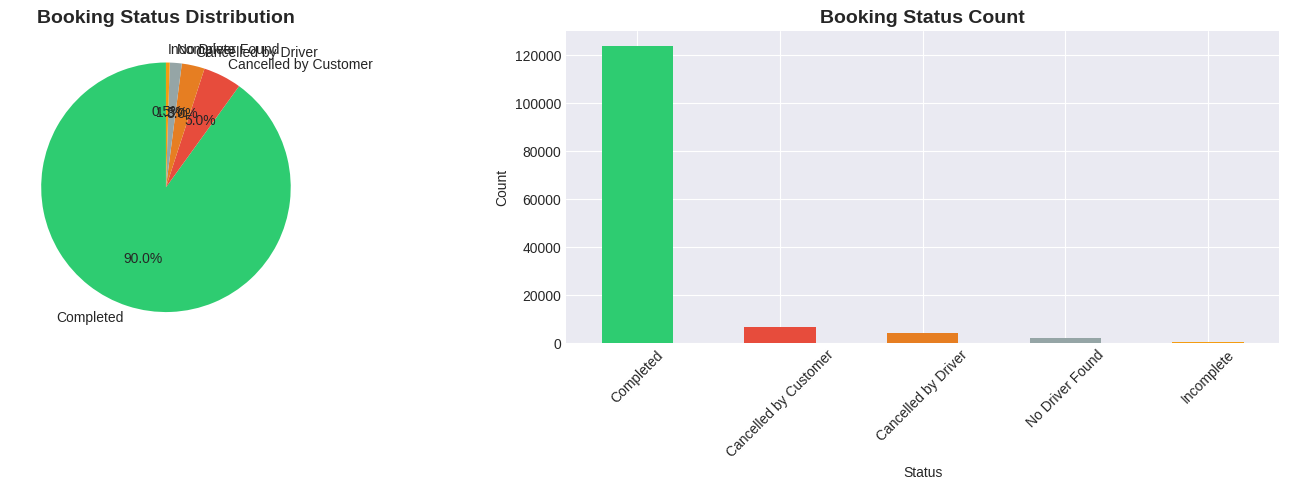

In [75]:
status = df[cfg.STATUS].value_counts()
status_pct = df[cfg.STATUS].value_counts(normalize=True).mul(100).round(2)
print(pd.DataFrame({'Count': status, 'Pct (%)': status_pct}))

COLORS = ['#2ecc71','#e74c3c','#e67e22','#95a5a6','#f39c12']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].pie(status, labels=status.index, autopct='%1.1f%%', colors=COLORS, startangle=90)
axes[0].set_title('Booking Status Distribution', fontsize=14, fontweight='bold')
status.plot(kind='bar', ax=axes[1], color=COLORS)
axes[1].set_title('Booking Status Count', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Status'); axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
savefig(fig, '01_booking_status')

---
## 6 · Revenue Trends

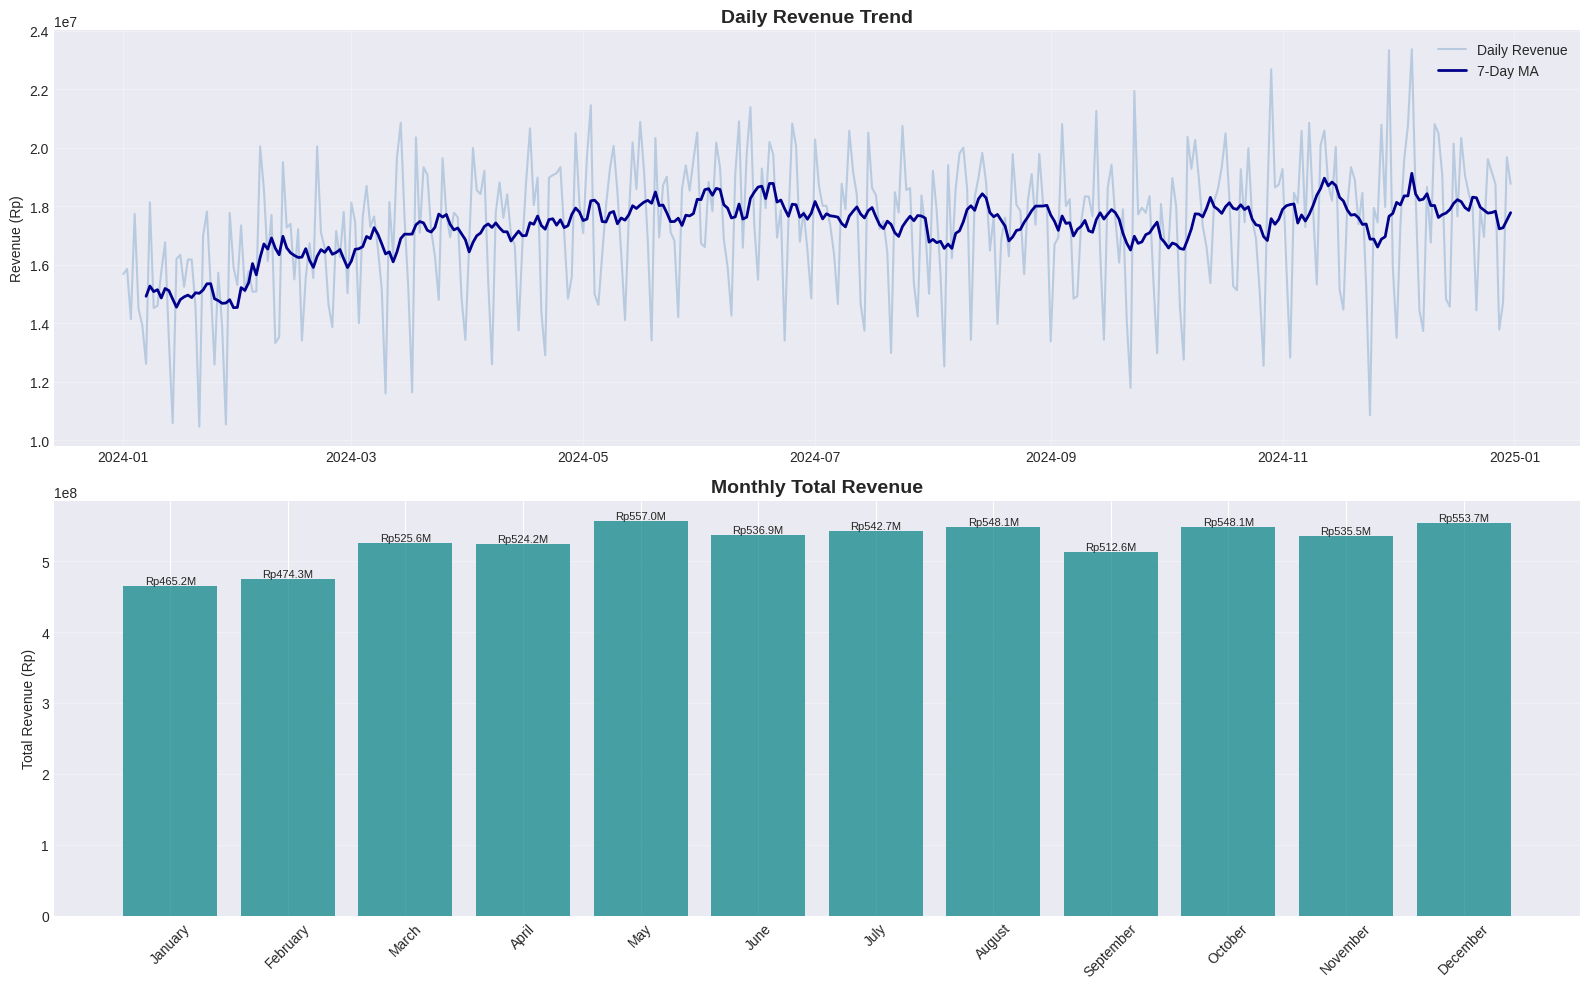


Monthly Revenue (Rp):
             Total Revenue
Month_Name                
January     Rp 465,231,700
February    Rp 474,259,300
March       Rp 525,642,900
April       Rp 524,159,100
May         Rp 557,028,800
June        Rp 536,880,400
July        Rp 542,699,800
August      Rp 548,096,200
September   Rp 512,559,000
October     Rp 548,116,600
November    Rp 535,467,100
December    Rp 553,726,000


In [76]:
daily = completed.groupby(cfg.DATE)[cfg.VALUE].sum().reset_index()
daily['Rolling'] = daily[cfg.VALUE].rolling(window=cfg.rolling_window).mean()

monthly = (
    completed.groupby('Month_Name')[cfg.VALUE].sum()
    .reindex([m for m in MONTH_ORDER if m in completed['Month_Name'].unique()])
)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

axes[0].plot(daily[cfg.DATE], daily[cfg.VALUE], alpha=0.3, label='Daily Revenue', color='steelblue')
axes[0].plot(daily[cfg.DATE], daily['Rolling'], label=f'{cfg.rolling_window}-Day MA', color='darkblue', linewidth=2)
axes[0].set_title('Daily Revenue Trend', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Revenue (Rp)'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

bars = axes[1].bar(monthly.index, monthly.values, color='teal', alpha=0.7)
axes[1].set_title('Monthly Total Revenue', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Revenue (Rp)')
axes[1].tick_params(axis='x', rotation=45); axes[1].grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, monthly.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, val, f'Rp{val/1e6:.1f}M',
                 ha='center', va='bottom', fontsize=8)
savefig(fig, '02_revenue_trends')

print('\nMonthly Revenue (Rp):')
print(monthly.map('Rp {:,.0f}'.format).to_frame('Total Revenue'))

---
## 7 · Vehicle Type Performance

                  Total_Rides  Total_Revenue  Avg_Revenue  Avg_Distance_km  \
Vehicle Type                                                                 
GrabCar                 10072   759333400.00     87400.25            13.59   
GoCar                   10207   722418300.00     82355.03            13.46   
GrabBike                20280   609679000.00     35170.41             8.69   
GoRide                  20129   569542600.00     32938.67             8.69   
inDriver Car             7478   481410900.00     74718.44            13.43   
GrabCar Plus             3885   409210300.00    123591.15            13.64   
inDriver Bike           15027   398776400.00     30627.99             8.65   
GoCar XL                 3769   355634000.00    109797.47            13.50   
Maxim Bike              14025   344960400.00     28492.64             8.74   
GrabCar 6 Seater         2537   296284600.00    135228.02            13.43   
BlueBird Silver          2457   274380200.00    129302.64       

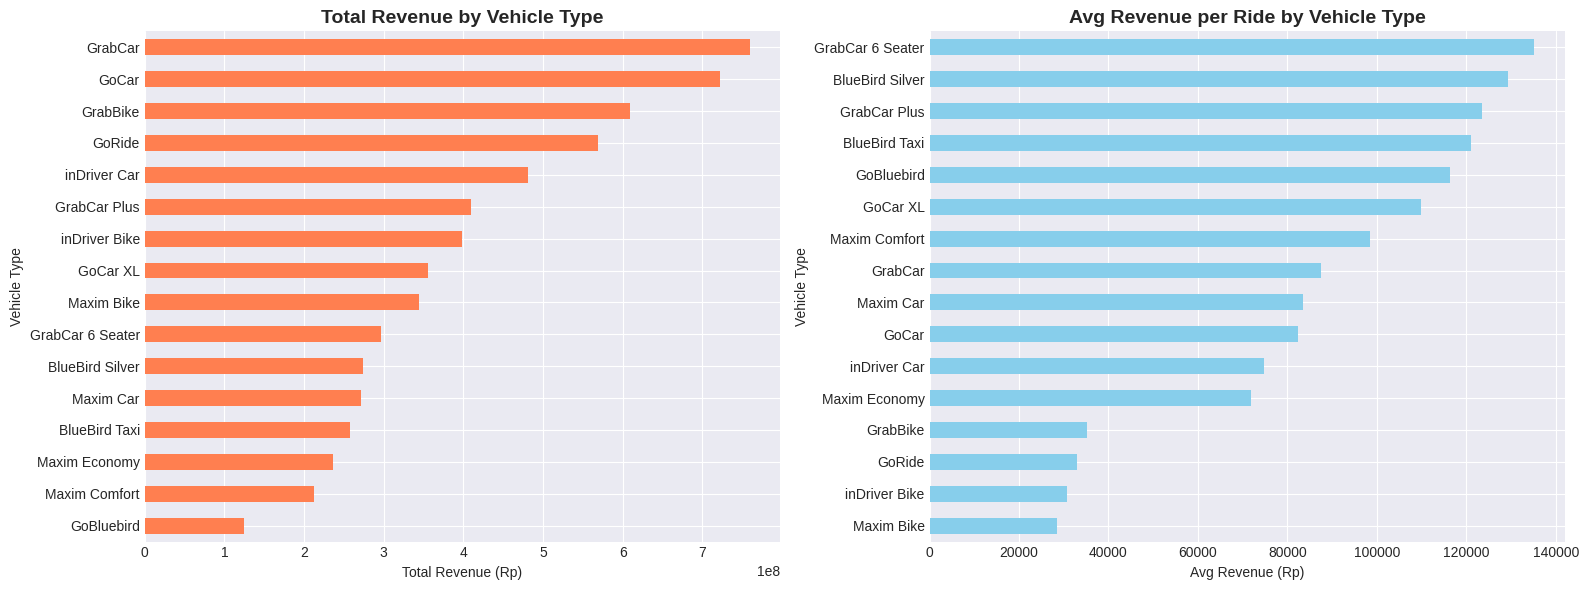

In [77]:
vehicle_perf = (
    completed.groupby(cfg.VEHICLE)
    .agg(
        Total_Rides        =(cfg.BOOKING_ID, 'count'),
        Total_Revenue      =(cfg.VALUE, 'sum'),
        Avg_Revenue        =(cfg.VALUE, 'mean'),
        Avg_Distance_km    =(cfg.DISTANCE, 'mean'),
        Avg_Driver_Rating  =(cfg.DRIVER_RATING, 'mean'),
        Avg_Customer_Rating=(cfg.CUST_RATING, 'mean'),
    )
    .round(2)
    .sort_values('Total_Revenue', ascending=False)
)
print(vehicle_perf)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
vehicle_perf.sort_values('Total_Revenue')['Total_Revenue'].plot(kind='barh', ax=axes[0], color='coral')
axes[0].set_title('Total Revenue by Vehicle Type', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Total Revenue (Rp)')

vehicle_perf.sort_values('Avg_Revenue')['Avg_Revenue'].plot(kind='barh', ax=axes[1], color='skyblue')
axes[1].set_title('Avg Revenue per Ride by Vehicle Type', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Avg Revenue (Rp)')
savefig(fig, '03_vehicle_performance')

---
## 8 · Payment Methods

                Count  Pct (%)
Payment Method                
GoPay           26594    24.99
OVO             21262    19.98
DANA            16038    15.07
Tunai           15934    14.97
ShopeePay       12733    11.96
Kartu Debit      8378     7.87
Kartu Kredit     5487     5.16


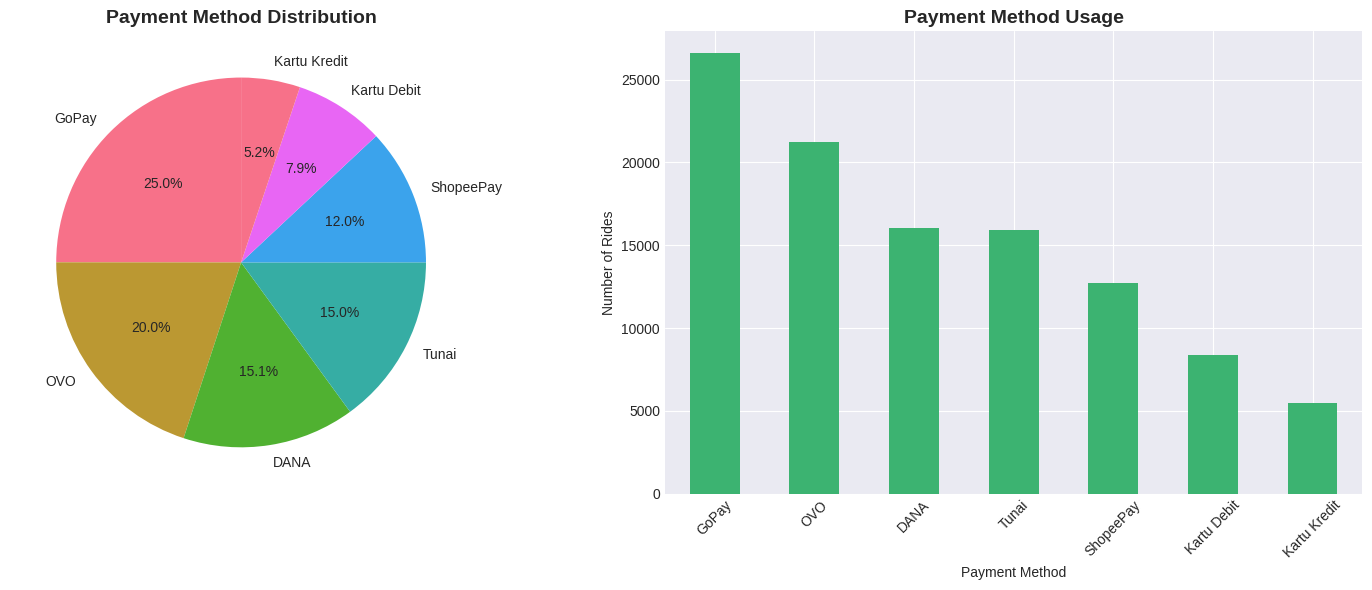

In [78]:
pay = completed[cfg.PAYMENT].value_counts()
print(pd.DataFrame({'Count': pay, 'Pct (%)': (pay/pay.sum()*100).round(2)}))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].pie(pay, labels=pay.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Payment Method Distribution', fontsize=14, fontweight='bold')
pay.plot(kind='bar', ax=axes[1], color='mediumseagreen')
axes[1].set_title('Payment Method Usage', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Payment Method'); axes[1].set_ylabel('Number of Rides')
axes[1].tick_params(axis='x', rotation=45)
savefig(fig, '04_payment_methods')

---
## 9 · Cancellation Analysis

Customer Cancellation Reasons:
Reason for cancelling by Customer
Berubah pikiran                                   1195
Waktu tunggu terlalu lama                          446
Pengemudi terlalu lama tiba                        407
Driver tidak bergerak ke lokasi penjemputan        377
Pengemudi tidak bergerak menuju titik jemput       329
Driver tidak responsif                             326
Salah pesan kendaraan                              303
Pengemudi tidak dapat dihubungi                    275
Pengemudi terlalu lama                             274
Harga tidak sesuai                                 266
Pengemudi terlalu lama datang                      234
Salah input lokasi penjemputan                     230
Pengemudi tidak bergerak ke titik jemput           194
Driver meminta untuk cancel                        192
Pengemudi tidak bisa dihubungi                     190
Salah pilih jenis layanan                          188
Pengemudi tidak menuju lokasi penjemputan          185


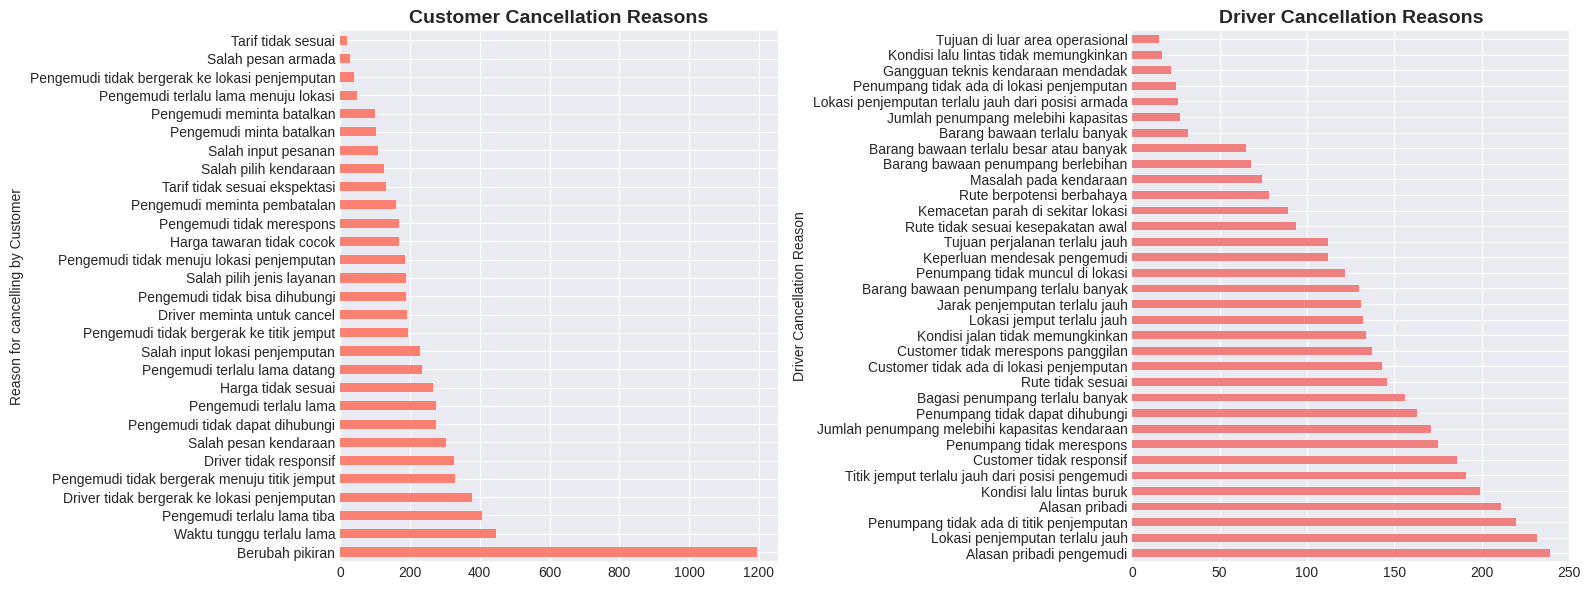

In [79]:
r_c = cancel_c_df[cfg.REASON_CUST].value_counts()   if cfg.REASON_CUST   in cancel_c_df.columns else pd.Series(dtype=int)
r_d = cancel_d_df[cfg.REASON_DRIVER].value_counts() if cfg.REASON_DRIVER in cancel_d_df.columns else pd.Series(dtype=int)

print('Customer Cancellation Reasons:'); print(r_c)
print('\nDriver Cancellation Reasons:');  print(r_d)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
if not r_c.empty: r_c.plot(kind='barh', ax=axes[0], color='salmon')
axes[0].set_title('Customer Cancellation Reasons', fontsize=14, fontweight='bold')
if not r_d.empty: r_d.plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_title('Driver Cancellation Reasons', fontsize=14, fontweight='bold')
savefig(fig, '05_cancellation_reasons')

---
## 10 · Rating Analysis

       Driver Rating  Customer Rating
count      123678.00        123678.00
mean            4.54             4.55
std             0.48             0.48
min             3.00             3.00
25%             4.50             4.50
50%             4.50             4.50
75%             5.00             5.00
max             5.00             5.00


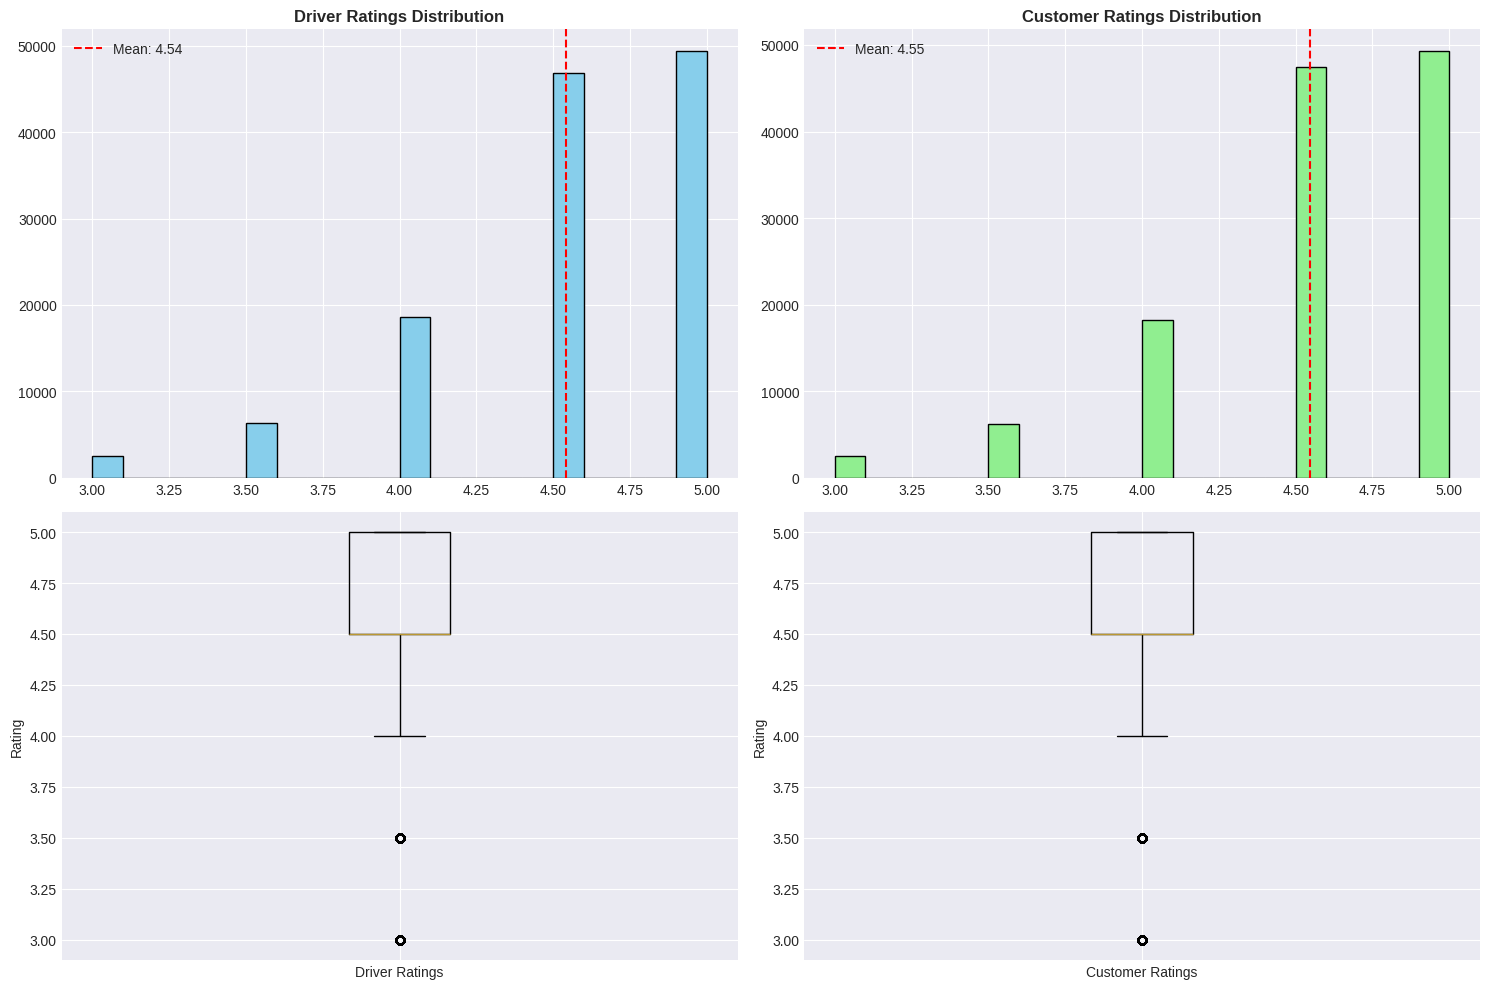


Avg Ratings by Vehicle Type:
                  Driver Ratings  Customer Rating
Vehicle Type                                     
GoBluebird                  4.57             4.55
GrabCar 6 Seater            4.56             4.54
BlueBird Taxi               4.55             4.54
BlueBird Silver             4.55             4.54
GoRide                      4.55             4.54
GoCar                       4.54             4.55
GrabBike                    4.54             4.55
GoCar XL                    4.54             4.56
GrabCar                     4.54             4.54
GrabCar Plus                4.54             4.53
Maxim Bike                  4.54             4.55
Maxim Car                   4.54             4.57
Maxim Comfort               4.54             4.53
Maxim Economy               4.54             4.55
inDriver Bike               4.54             4.55
inDriver Car                4.54             4.54


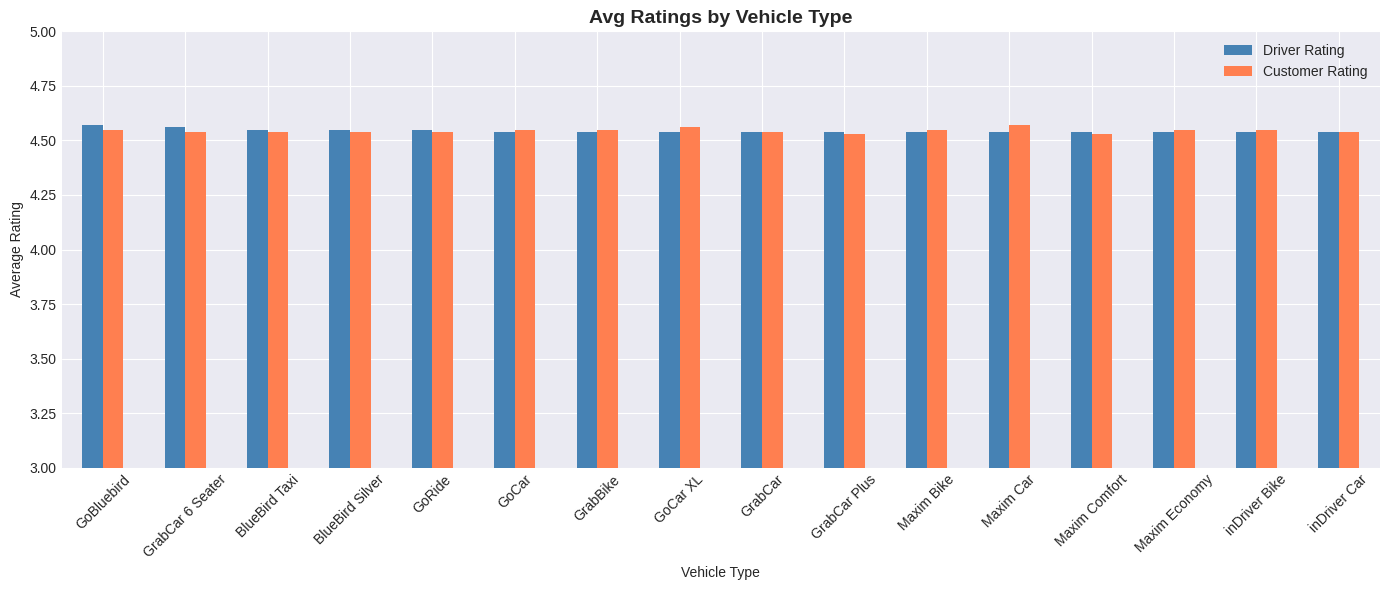

In [80]:
dr = completed[cfg.DRIVER_RATING].dropna()
cr = completed[cfg.CUST_RATING].dropna()

print(pd.DataFrame({'Driver Rating': dr.describe(), 'Customer Rating': cr.describe()}))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, data, label, color in [
    (axes[0,0], dr, 'Driver',   'skyblue'),
    (axes[0,1], cr, 'Customer', 'lightgreen'),
]:
    ax.hist(data, bins=20, color=color, edgecolor='black')
    ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.2f}')
    ax.set_title(f'{label} Ratings Distribution', fontsize=12, fontweight='bold')
    ax.legend()

for ax, data, label in [
    (axes[1,0], dr, 'Driver Ratings'),
    (axes[1,1], cr, 'Customer Ratings'),
]:
    ax.boxplot([data], labels=[label]); ax.set_ylabel('Rating')
savefig(fig, '06_ratings_distribution')

# Ratings by vehicle
v_ratings = (
    completed.groupby(cfg.VEHICLE)[[cfg.DRIVER_RATING, cfg.CUST_RATING]]
    .mean().round(2).sort_values(cfg.DRIVER_RATING, ascending=False)
)
print('\nAvg Ratings by Vehicle Type:'); print(v_ratings)

fig2, ax2 = plt.subplots(figsize=(14, 6))
v_ratings.plot(kind='bar', ax=ax2, color=['steelblue','coral'])
ax2.set_title('Avg Ratings by Vehicle Type', fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Rating'); ax2.set_ylim(3.0, 5.0)
ax2.legend(['Driver Rating','Customer Rating'])
ax2.tick_params(axis='x', rotation=45)
savefig(fig2, '07_ratings_by_vehicle')

---
## 11 · Peak Hours

Top 5 Peak Hours (by bookings):
    Hour  Bookings
7      7     11095
17    17     11064
8      8      9680
18    18      9568
16    16      8145


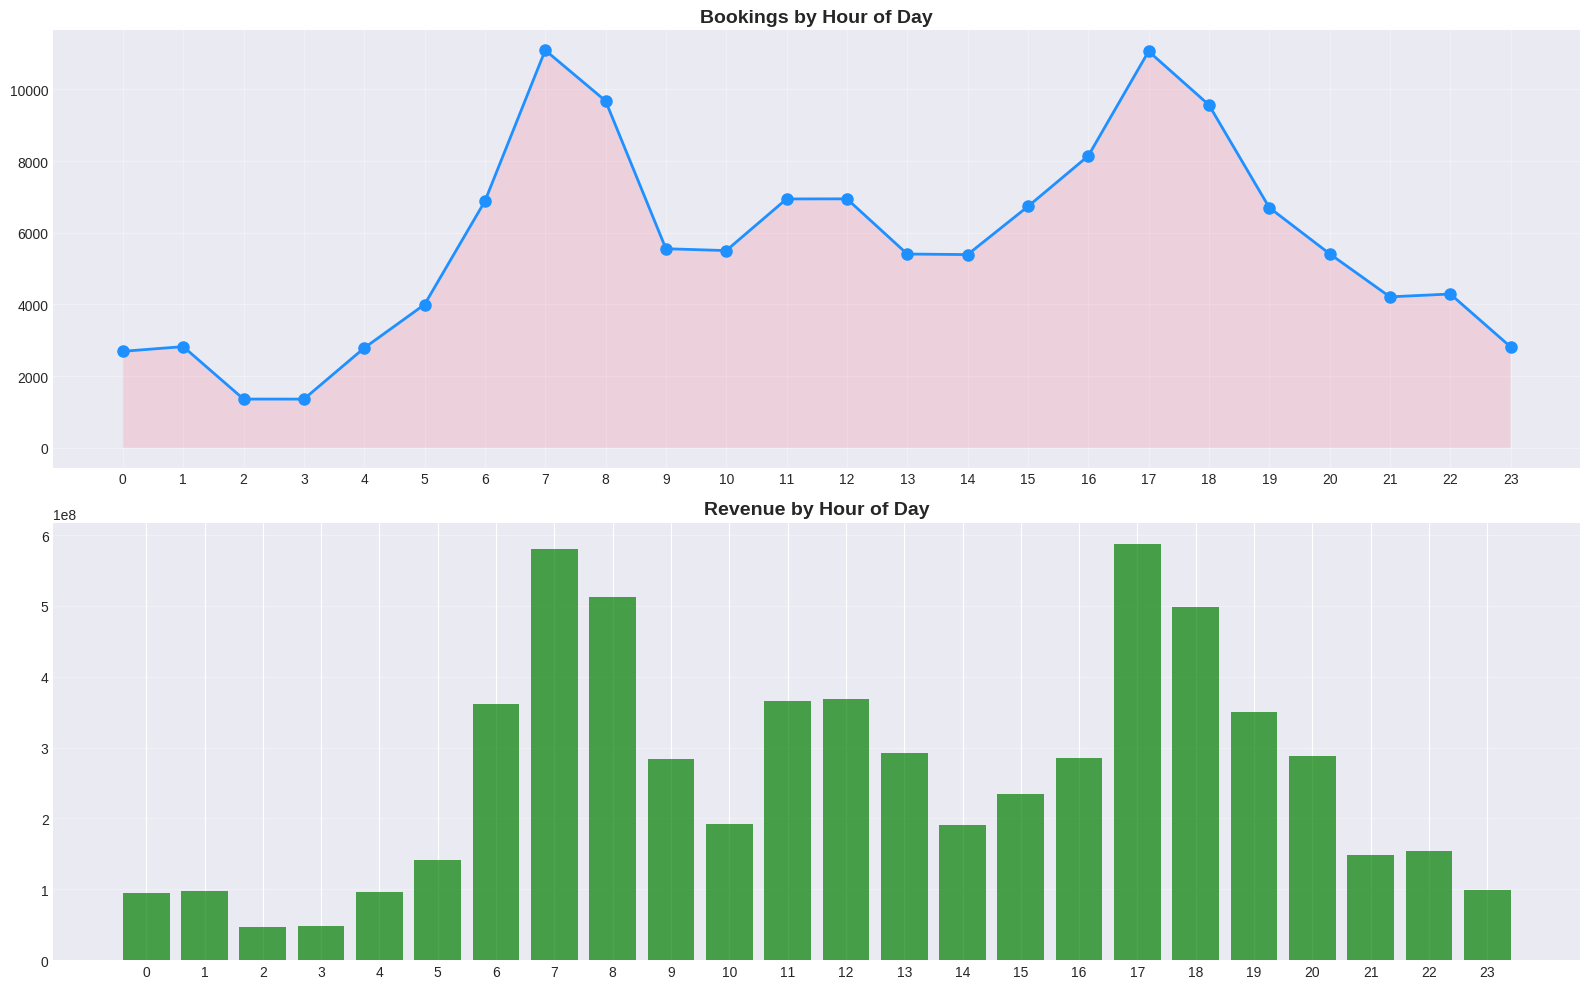

In [81]:
hourly     = df.groupby('Hour').size().reset_index(name='Bookings')
hourly_rev = completed.groupby('Hour')[cfg.VALUE].sum().reset_index()

print('Top 5 Peak Hours (by bookings):')
print(hourly.sort_values('Bookings', ascending=False).head())

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
axes[0].plot(hourly['Hour'], hourly['Bookings'], marker='o', linewidth=2, markersize=8, color='dodgerblue')
axes[0].fill_between(hourly['Hour'], hourly['Bookings'], alpha=0.2)
axes[0].set_title('Bookings by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(24)); axes[0].grid(True, alpha=0.3)

axes[1].bar(hourly_rev['Hour'], hourly_rev[cfg.VALUE], color='green', alpha=0.7)
axes[1].set_title('Revenue by Hour of Day', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(24)); axes[1].grid(True, alpha=0.3, axis='y')
savefig(fig, '08_peak_hours')

---
## 12 · Day of Week Patterns

Bookings by Day:
DayOfWeek_Name
Monday       21096
Tuesday      20939
Wednesday    20749
Thursday     20699
Friday       20576
Saturday     17838
Sunday       15467
dtype: int64


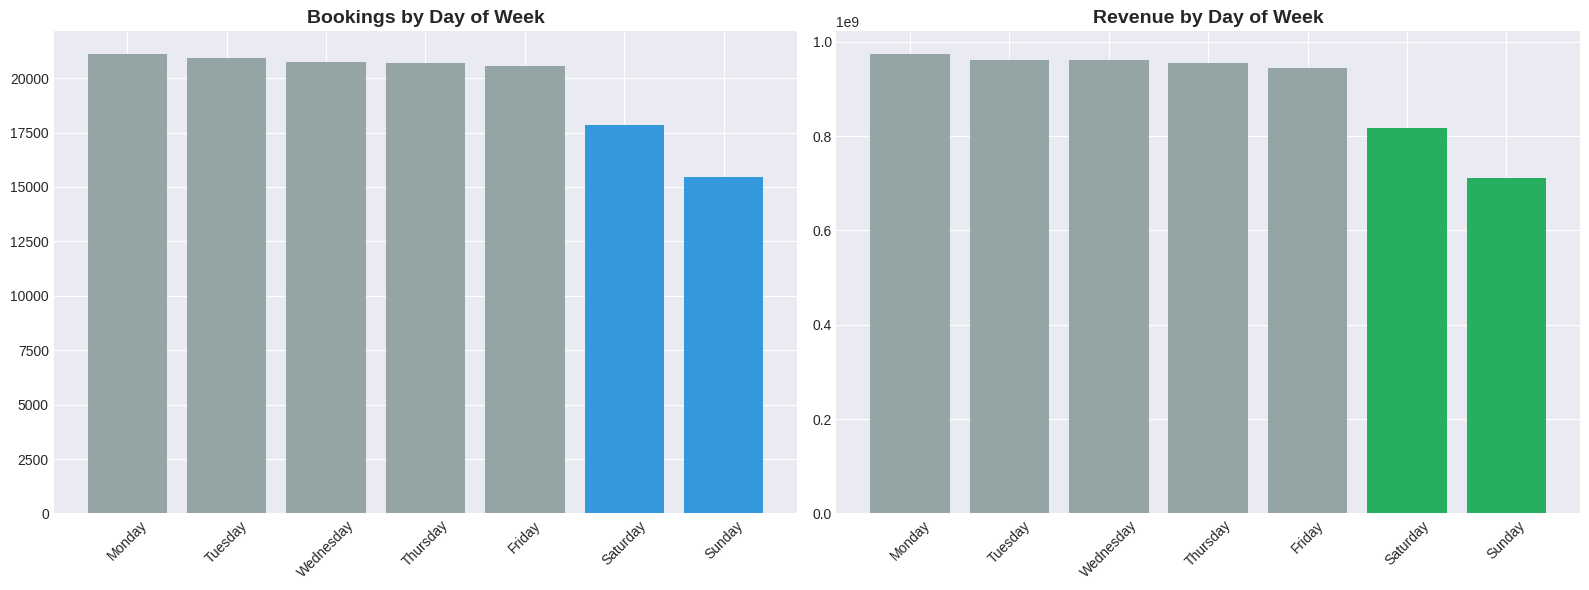

In [82]:
def reorder(series, order):
    return series.reindex([d for d in order if d in series.index])

bk_day  = reorder(df.groupby('DayOfWeek_Name').size(), DAY_ORDER)
rev_day = reorder(completed.groupby('DayOfWeek_Name')[cfg.VALUE].sum(), DAY_ORDER)

def day_colors(index, wknd, wkdy):
    return [wknd if d in WEEKENDS else wkdy for d in index]

print('Bookings by Day:'); print(bk_day)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].bar(bk_day.index, bk_day.values, color=day_colors(bk_day.index, '#3498db', '#95a5a6'))
axes[0].set_title('Bookings by Day of Week', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(rev_day.index, rev_day.values, color=day_colors(rev_day.index, '#27ae60', '#95a5a6'))
axes[1].set_title('Revenue by Day of Week', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
savefig(fig, '09_day_of_week')

---
## 13 · Time Period Analysis

Time_Period
Morning      49656
Afternoon    32624
Evening      32749
Night        22335
dtype: int64


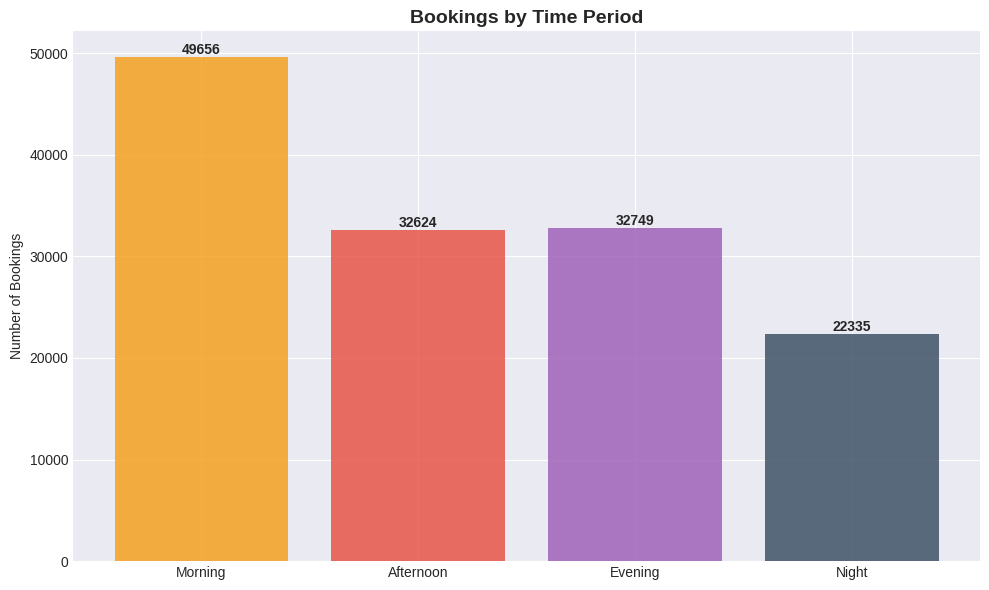

In [83]:
tp = df.groupby('Time_Period').size().reindex(PERIOD_ORDER).dropna()
print(tp)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(tp.index, tp.values, color=['#f39c12','#e74c3c','#9b59b6','#34495e'], alpha=0.8)
ax.set_title('Bookings by Time Period', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Bookings')
for bar, val in zip(bars, tp.values):
    ax.text(bar.get_x() + bar.get_width()/2, val, str(val), ha='center', va='bottom', fontweight='bold')
savefig(fig, '10_time_period')

---
## 14 · Ride Distance Analysis

Distance stats (km):
count   123678.00
mean        10.81
std          6.69
min          2.50
25%          5.93
50%          9.16
75%         14.55
max         45.00
Name: Ride Distance, dtype: float64

Distance categories:
Distance_Category
Short (<5 km)         21997
Medium (5–15 km)      72893
Long (15–30 km)       26097
Very Long (>30 km)     2691
Name: count, dtype: int64


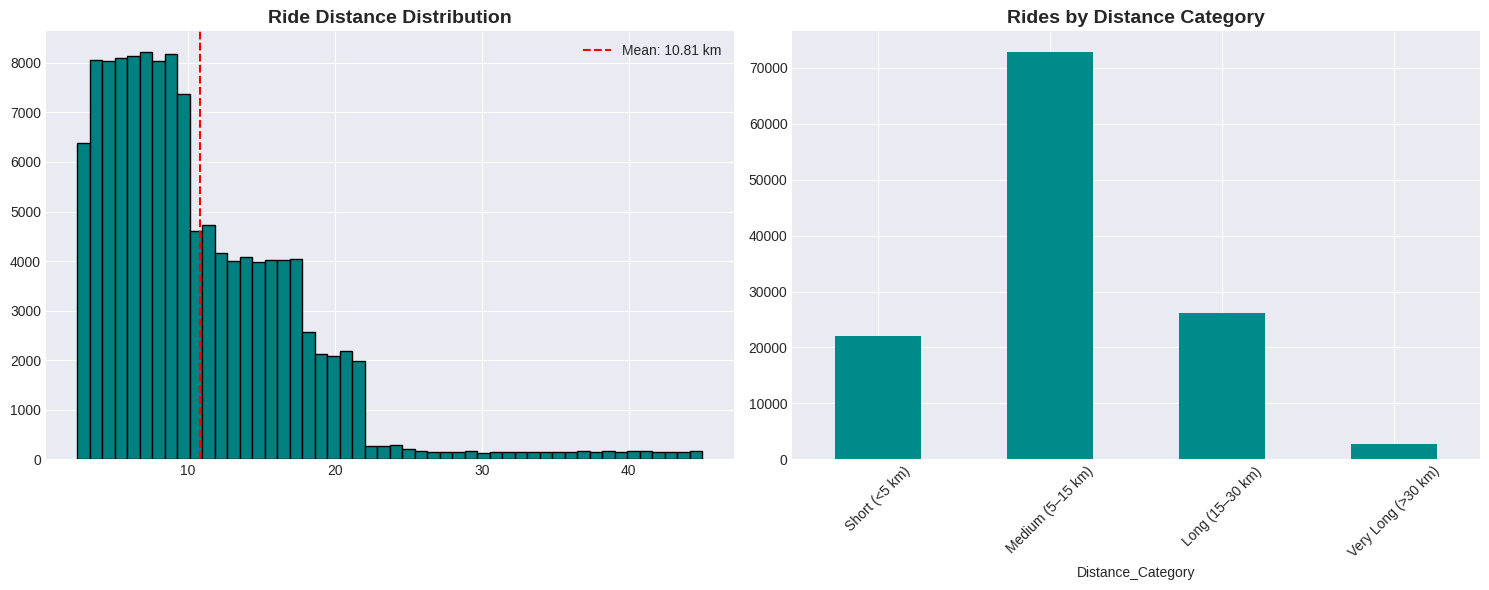

In [84]:
dist = completed[cfg.DISTANCE].dropna()
dist_cat_counts = (
    completed['Distance_Category'].value_counts()
    .reindex([d for d in DIST_ORDER if d in completed['Distance_Category'].unique()])
)

print(f'Distance stats (km):\n{dist.describe()}')
print(f'\nDistance categories:\n{dist_cat_counts}')

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].hist(dist, bins=50, color='teal', edgecolor='black')
axes[0].axvline(dist.mean(), color='red', linestyle='--', label=f'Mean: {dist.mean():.2f} km')
axes[0].set_title('Ride Distance Distribution', fontsize=14, fontweight='bold')
axes[0].legend()

dist_cat_counts.plot(kind='bar', ax=axes[1], color='darkcyan')
axes[1].set_title('Rides by Distance Category', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
savefig(fig, '11_distance')

---
## 15 · Geographic Analysis

Top Pickup Locations:
Pickup Location
Margonda             2262
Citayam              2195
Lenteng Agung        2179
UI Depok             2155
Depok Town Square    2154
Margo City           2128
Gading Serpong       2054
Tajur                2053
Pancoran Mas         2042
Dramaga              2000
Bogor Trade Mall     1987
Kebun Raya Bogor     1978
Botani Square        1954
Bogor Station        1938
Ekalokasari Plaza    1937
Name: count, dtype: int64

Top Drop Locations:
Drop Location
Botani Square        2459
Dramaga              2434
Kebun Raya Bogor     2402
Ekalokasari Plaza    2400
Bogor Trade Mall     2387
Tajur                2367
Bogor Station        2362
UI Depok             2238
Depok Town Square    2198
Margonda             2188
Pancoran Mas         2170
Margo City           2142
Lenteng Agung        2108
Citayam              2098
Gading Serpong       1952
Name: count, dtype: int64


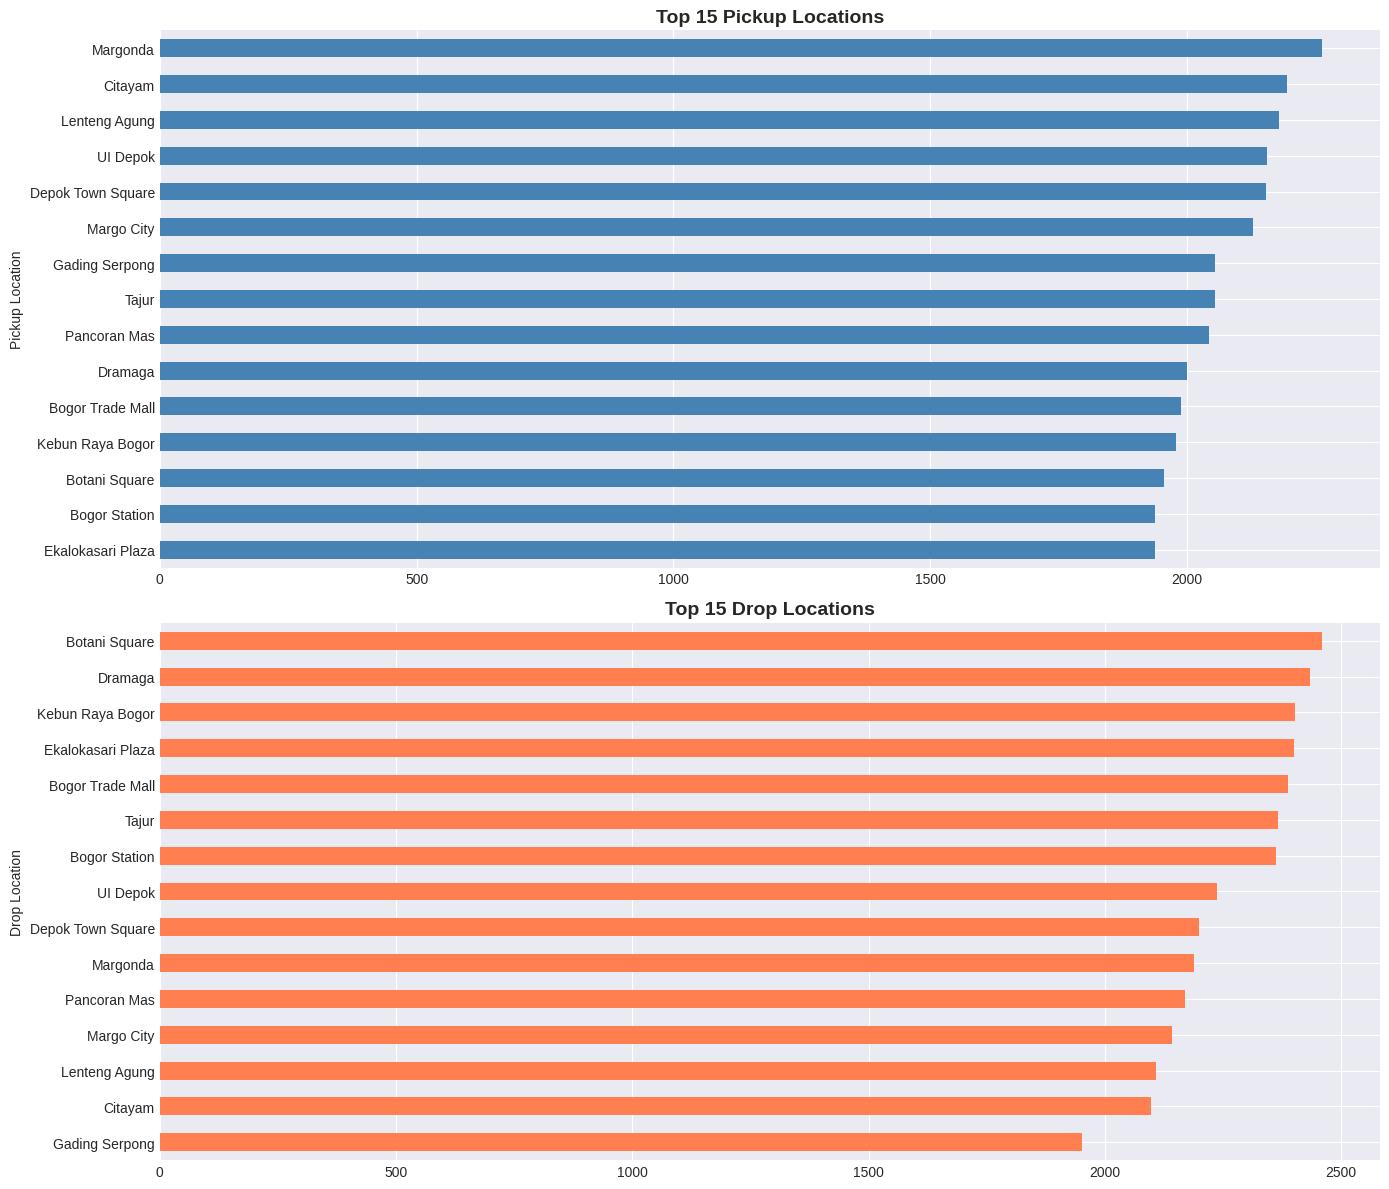

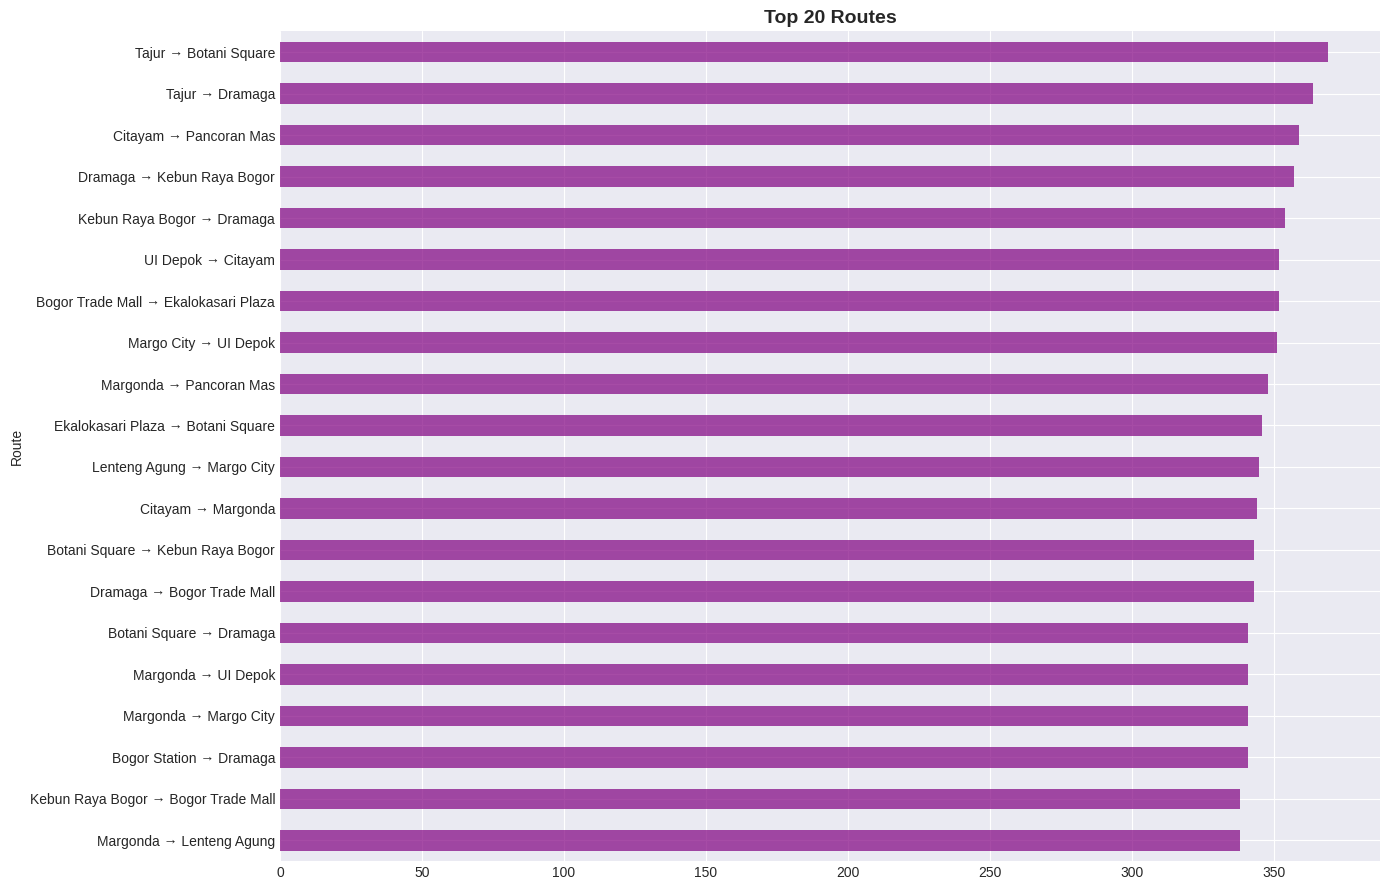

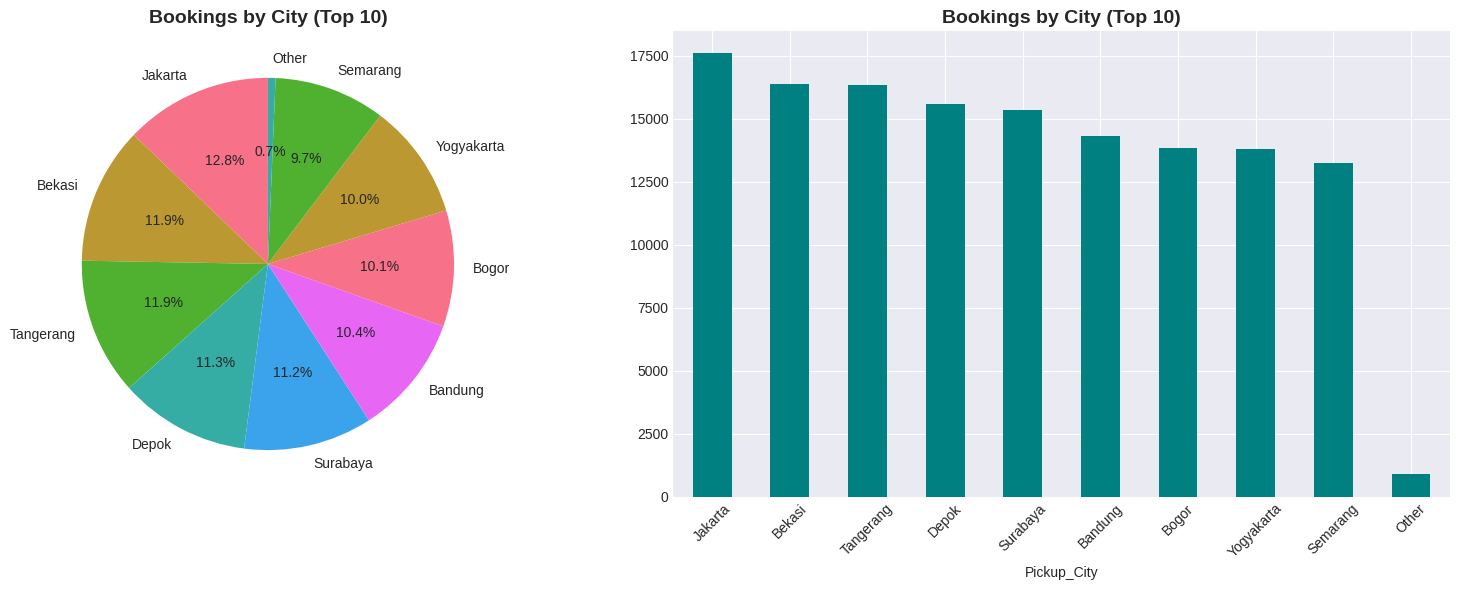

In [85]:
top_p  = df[cfg.PICKUP].value_counts().head(cfg.top_n_locations)
top_d  = df[cfg.DROP].value_counts().head(cfg.top_n_locations)
top_r  = df['Route'].value_counts().head(cfg.top_n_routes)
cities = df['Pickup_City'].value_counts()

print('Top Pickup Locations:'); print(top_p)
print('\nTop Drop Locations:');  print(top_d)

# Pickup & Drop
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
top_p.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title(f'Top {cfg.top_n_locations} Pickup Locations', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
top_d.plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title(f'Top {cfg.top_n_locations} Drop Locations', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
savefig(fig, '12_pickup_drop_locations')

# Top routes
fig2, ax2 = plt.subplots(figsize=(14, 9))
top_r.plot(kind='barh', ax=ax2, color='purple', alpha=0.7)
ax2.set_title(f'Top {cfg.top_n_routes} Routes', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
savefig(fig2, '13_top_routes')

# City distribution
fig3, axes3 = plt.subplots(1, 2, figsize=(16, 6))
axes3[0].pie(cities.head(10), labels=cities.head(10).index, autopct='%1.1f%%', startangle=90)
axes3[0].set_title('Bookings by City (Top 10)', fontsize=14, fontweight='bold')
cities.head(10).plot(kind='bar', ax=axes3[1], color='teal')
axes3[1].set_title('Bookings by City (Top 10)', fontsize=14, fontweight='bold')
axes3[1].tick_params(axis='x', rotation=45)
savefig(fig3, '14_city_distribution')

---
## 16 · Correlation & Revenue vs Distance

                 Booking Value  Ride Distance  Avg VTAT  Avg CTAT  \
Booking Value             1.00           0.82      0.35      0.04   
Ride Distance             0.82           1.00      0.22      0.00   
Avg VTAT                  0.35           0.22      1.00     -0.01   
Avg CTAT                  0.04           0.00     -0.01      1.00   
Driver Ratings           -0.00          -0.00      0.00     -0.00   
Customer Rating          -0.00           0.00     -0.00      0.00   

                 Driver Ratings  Customer Rating  
Booking Value             -0.00            -0.00  
Ride Distance             -0.00             0.00  
Avg VTAT                   0.00            -0.00  
Avg CTAT                  -0.00             0.00  
Driver Ratings             1.00            -0.00  
Customer Rating           -0.00             1.00  


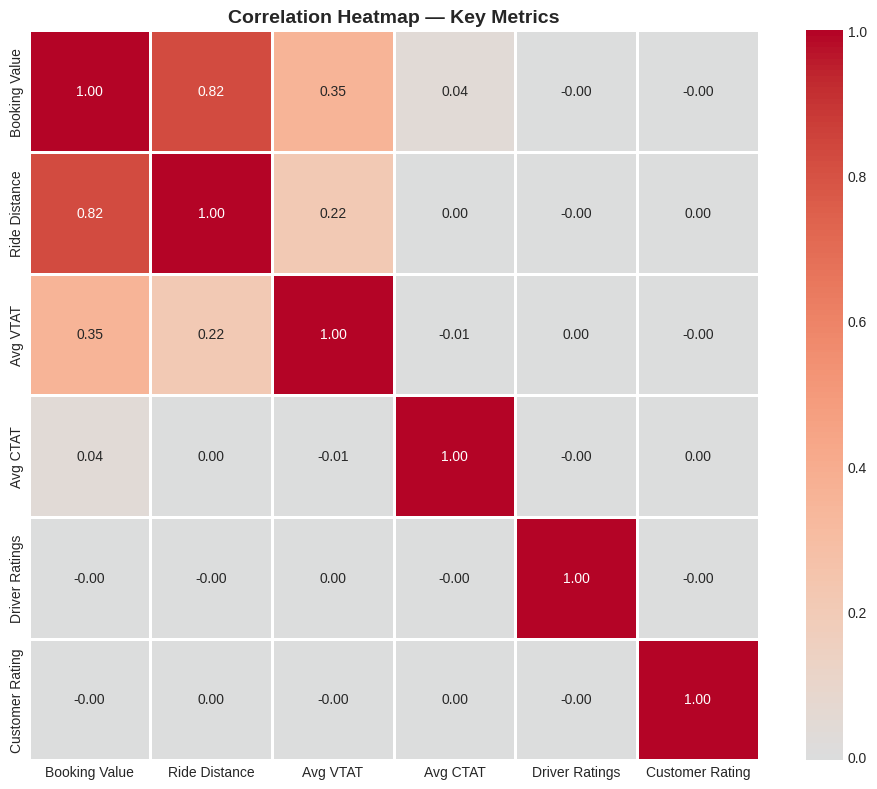

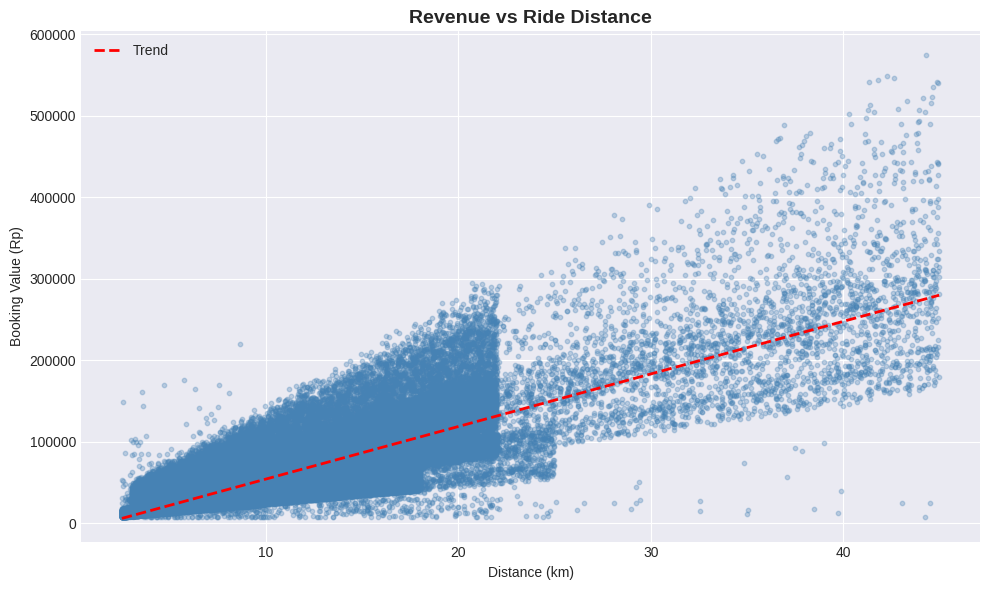

In [86]:
corr_cols = [cfg.VALUE, cfg.DISTANCE, cfg.VTAT, cfg.CTAT, cfg.DRIVER_RATING, cfg.CUST_RATING]
corr = completed[corr_cols].corr()
print(corr.round(3))

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, square=True, linewidths=1, fmt='.2f', ax=ax)
ax.set_title('Correlation Heatmap — Key Metrics', fontsize=14, fontweight='bold')
savefig(fig, '15_correlation_heatmap')

valid = completed[[cfg.DISTANCE, cfg.VALUE]].dropna()
z = np.polyfit(valid[cfg.DISTANCE], valid[cfg.VALUE], 1)

fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.scatter(valid[cfg.DISTANCE], valid[cfg.VALUE], alpha=0.3, s=10, c='steelblue')
ax2.plot(np.sort(valid[cfg.DISTANCE]), np.poly1d(z)(np.sort(valid[cfg.DISTANCE])),
         'r--', linewidth=2, label='Trend')
ax2.set_title('Revenue vs Ride Distance', fontsize=14, fontweight='bold')
ax2.set_xlabel('Distance (km)'); ax2.set_ylabel('Booking Value (Rp)')
ax2.legend()
savefig(fig2, '16_revenue_vs_distance')

---
## 17 · Monthly Cohort Performance

            Total_Rides  Total_Revenue  Avg_Driver_Rating  \
Month_Name                                                  
January            9293   465231700.00               4.54   
February           9166   474259300.00               4.54   
March             10300   525642900.00               4.54   
April             10349   524159100.00               4.55   
May               10903   557028800.00               4.54   
June              10438   536880400.00               4.54   
July              10788   542699800.00               4.54   
August            10642   548096200.00               4.54   
September          9833   512559000.00               4.55   
October           10728   548116600.00               4.54   
November          10448   535467100.00               4.54   
December          10790   553726000.00               4.54   

            Avg_Customer_Rating  Avg_VTAT  Avg_CTAT  
Month_Name                                           
January                    4.54      

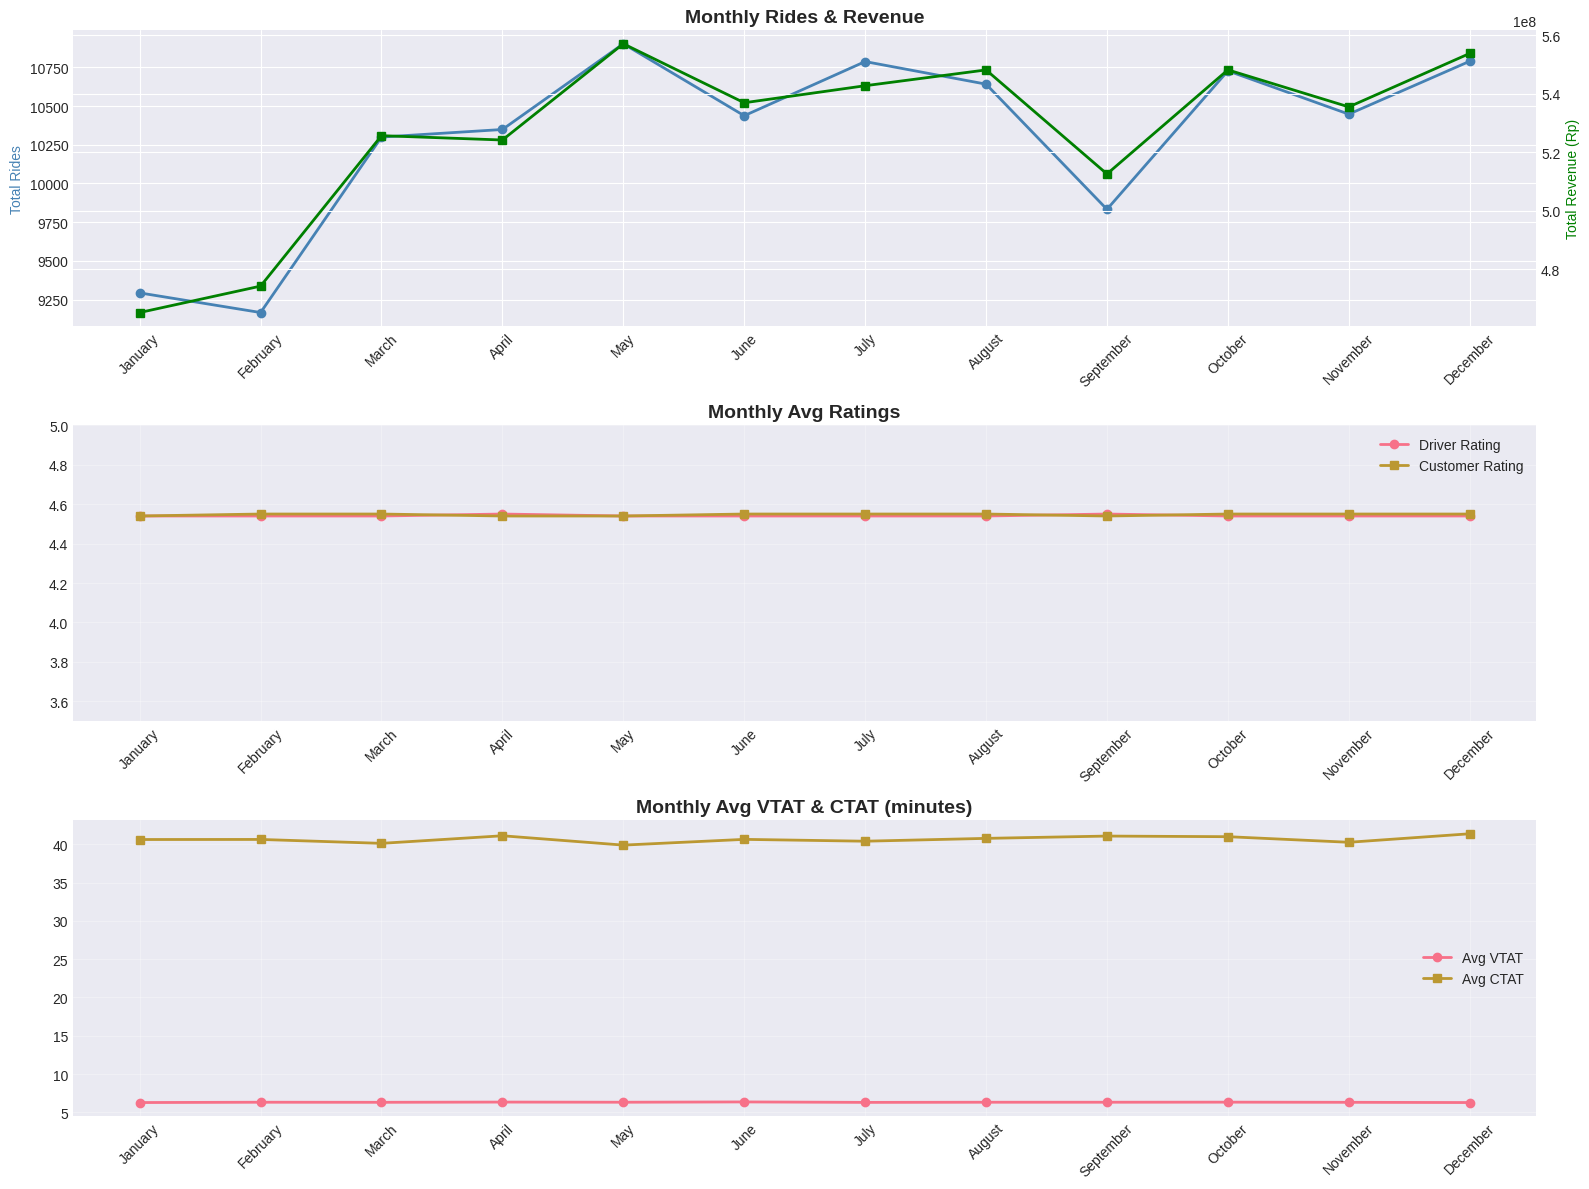

In [87]:
monthly_cohort = (
    completed.groupby('Month_Name')
    .agg(
        Total_Rides        =(cfg.BOOKING_ID, 'count'),
        Total_Revenue      =(cfg.VALUE, 'sum'),
        Avg_Driver_Rating  =(cfg.DRIVER_RATING, 'mean'),
        Avg_Customer_Rating=(cfg.CUST_RATING, 'mean'),
        Avg_VTAT           =(cfg.VTAT, 'mean'),
        Avg_CTAT           =(cfg.CTAT, 'mean'),
    )
    .round(2)
    .reindex([m for m in MONTH_ORDER if m in completed['Month_Name'].unique()])
)
print(monthly_cohort)

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

ax1, ax1r = axes[0], axes[0].twinx()
ax1.plot(monthly_cohort.index, monthly_cohort['Total_Rides'], marker='o', color='steelblue', linewidth=2, label='Total Rides')
ax1r.plot(monthly_cohort.index, monthly_cohort['Total_Revenue'], marker='s', color='green', linewidth=2, label='Total Revenue')
ax1.set_ylabel('Total Rides', color='steelblue'); ax1r.set_ylabel('Total Revenue (Rp)', color='green')
ax1.set_title('Monthly Rides & Revenue', fontsize=14, fontweight='bold')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

axes[1].plot(monthly_cohort.index, monthly_cohort['Avg_Driver_Rating'], marker='o', linewidth=2, label='Driver Rating')
axes[1].plot(monthly_cohort.index, monthly_cohort['Avg_Customer_Rating'], marker='s', linewidth=2, label='Customer Rating')
axes[1].set_title('Monthly Avg Ratings', fontsize=14, fontweight='bold')
axes[1].set_ylim(3.5, 5.0); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)

axes[2].plot(monthly_cohort.index, monthly_cohort['Avg_VTAT'], marker='o', linewidth=2, label='Avg VTAT')
axes[2].plot(monthly_cohort.index, monthly_cohort['Avg_CTAT'], marker='s', linewidth=2, label='Avg CTAT')
axes[2].set_title('Monthly Avg VTAT & CTAT (minutes)', fontsize=14, fontweight='bold')
axes[2].legend(); axes[2].grid(True, alpha=0.3)
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45)

savefig(fig, '17_monthly_cohort')

---
## 18 · Operational Timing (VTAT & CTAT)

In [88]:
print(pd.DataFrame({
    'VTAT (minutes)': df[cfg.VTAT].describe(),
    'CTAT (minutes)': df[cfg.CTAT].describe(),
}))
print('\nVTAT = Vehicle Time to Arrive at pickup')
print('CTAT = Customer Time on the whole trip')

       VTAT (minutes)  CTAT (minutes)
count       137364.00       116796.00
mean             6.33           40.61
std              2.50           33.70
min              2.00            3.40
25%              4.43           16.50
50%              6.12           29.70
75%              7.81           54.00
max             12.00          272.00

VTAT = Vehicle Time to Arrive at pickup
CTAT = Customer Time on the whole trip


---
## 19 · Executive Summary & Recommendations

In [92]:
peak_hour = df.groupby('Hour').size().idxmax()
peak_day  = df.groupby('DayOfWeek_Name').size().idxmax()
top_pay   = completed[cfg.PAYMENT].value_counts().index[0]

SEP = '=' * 65
print(f'''
{SEP}
EXECUTIVE SUMMARY
{SEP}

1. BUSINESS PERFORMANCE
   Completion Rate  : {completion_rate:.2f}% ({label})
   Total Revenue    : Rp {total_revenue:,.0f}
   Avg Transaction  : Rp {avg_value:,.0f}
   Cancellation Rate: {cancellation_rate:.2f}%

2. CUSTOMER BEHAVIOR
   Top Payment      : {top_pay}
   Avg Driver Rating: {completed[cfg.DRIVER_RATING].mean():.2f} / 5.0
   Avg Cust. Rating : {completed[cfg.CUST_RATING].mean():.2f} / 5.0
   Top Cancel (Cust): {r_c.index[0] if not r_c.empty else 'N/A'}
   Top Cancel (Drvr): {r_d.index[0] if not r_d.empty else 'N/A'}

3. OPERATIONAL INSIGHTS
   Peak Hour        : {peak_hour:02d}:00
   Busiest Day      : {peak_day}
   Avg VTAT         : {df[cfg.VTAT].mean():.1f} min
   Avg CTAT         : {df[cfg.CTAT].mean():.1f} min
   Avg Distance     : {completed[cfg.DISTANCE].mean():.2f} km

4. GEOGRAPHIC & VEHICLE
   Top Pickup       : {top_p.index[0]}
   Top Drop         : {top_d.index[0]}
   Top Route        : {top_r.index[0]}
   Dominant City    : {cities.index[0]}
   Top Revenue Veh. : {vehicle_perf['Total_Revenue'].idxmax()}

{SEP}
RECOMMENDATIONS
{SEP}

📊 Business Strategy
   • Surge pricing during peak hours & weekends
   • Target marketing campaigns in evening slots
   • Increase driver supply incentives on weekends

👥 Customer Experience
   • Resolve top cancellation causes via driver training
   • Improve ETA accuracy to reduce no-show cancellations
   • Enhance in-app location pin precision

🚗 Operational Efficiency
   • Pre-position drivers in high-demand zones before peak hours
   • Set VTAT reduction as a primary SLA target
   • Analyse high-CTAT routes for route optimisation

💰 Revenue Optimisation
   • Promote digital wallet adoption (lower processing costs)
   • Launch loyalty programme for frequent riders
   • Bundle corridor-specific promotions on top routes
{SEP}
''')


EXECUTIVE SUMMARY

1. BUSINESS PERFORMANCE
   Completion Rate  : 90.04% (EXCELLENT ✓)
   Total Revenue    : Rp 6,323,866,900
   Avg Transaction  : Rp 59,420
   Cancellation Rate: 9.96%

2. CUSTOMER BEHAVIOR
   Top Payment      : GoPay
   Avg Driver Rating: 4.54 / 5.0
   Avg Cust. Rating : 4.55 / 5.0
   Top Cancel (Cust): Berubah pikiran
   Top Cancel (Drvr): Alasan pribadi pengemudi

3. OPERATIONAL INSIGHTS
   Peak Hour        : 07:00
   Busiest Day      : Monday
   Avg VTAT         : 6.3 min
   Avg CTAT         : 40.6 min
   Avg Distance     : 10.81 km

4. GEOGRAPHIC & VEHICLE
   Top Pickup       : Margonda
   Top Drop         : Botani Square
   Top Route        : Tajur → Botani Square
   Dominant City    : Jakarta
   Top Revenue Veh. : GrabCar

RECOMMENDATIONS

📊 Business Strategy
   • Surge pricing during peak hours & weekends
   • Target marketing campaigns in evening slots
   • Increase driver supply incentives on weekends

👥 Customer Experience
   • Resolve top cancellation caus

---
## 20 · Export Reports

In [46]:
# Summary KPIs
pd.DataFrame([
    ('Total Bookings',         total),
    ('Completed Bookings',     comp_count),
    ('Completion Rate (%)',    round(completion_rate, 2)),
    ('Cancellation Rate (%)',  round(cancellation_rate, 2)),
    ('Total Revenue (Rp)',     round(total_revenue)),
    ('Avg Booking Value (Rp)', round(avg_value)),
    ('Avg Distance (km)',      round(completed[cfg.DISTANCE].mean(), 2)),
    ('Avg Driver Rating',      round(completed[cfg.DRIVER_RATING].mean(), 2)),
    ('Avg Customer Rating',    round(completed[cfg.CUST_RATING].mean(), 2)),
    ('Avg VTAT (min)',         round(df[cfg.VTAT].mean(), 1)),
    ('Avg CTAT (min)',         round(df[cfg.CTAT].mean(), 1)),
    ('Peak Hour',              f'{peak_hour:02d}:00'),
    ('Busiest Day',            peak_day),
    ('Top Payment Method',     top_pay),
    ('Top Vehicle (Revenue)',  vehicle_perf['Total_Revenue'].idxmax()),
], columns=['Metric', 'Value']).to_csv(OUT / 'summary_kpis.csv', index=False)

# Vehicle performance
vehicle_perf.to_csv(OUT / 'vehicle_performance.csv')

# Monthly performance
monthly_cohort.to_csv(OUT / 'monthly_performance.csv')

print(f'✓ Reports exported to {OUT.resolve()}/')
print('   summary_kpis.csv')
print('   vehicle_performance.csv')
print('   monthly_performance.csv')
print(f'\n✓ {len(list(OUT.glob("*.png")))} chart(s) saved')
print('\n🏁 Analysis complete!')

✓ Reports exported to /content/output/
   summary_kpis.csv
   vehicle_performance.csv
   monthly_performance.csv

✓ 17 chart(s) saved

🏁 Analysis complete!
